In [1]:
# This cell is tagged for removal

import os
import math
import pickle
from glob import glob

import numpy as np
import pandas as pd
from IPython import display as idisplay

from sklearn.metrics import r2_score

import aliases # important this goes first to configure PATH

from everest.window import Canvas, plot, raster, DataChannel as Channel, get_cmap
from everest.window.colourmaps import *
from everest.window import image, imop

from referencing import search
from myst_nb import glue
from analysis import isovisc, arrhenius, utilities, common, analysis, visualisation
%matplotlib inline

osjoin = os.path.join

import warnings

warnings.filterwarnings("ignore",category=UserWarning)

In [2]:
with open(osjoin(aliases.storagedir, 'condh.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condgeotherms, condavts, condhs = (conddata[key] for key in ('geotherms', 'avts', 'hs'))

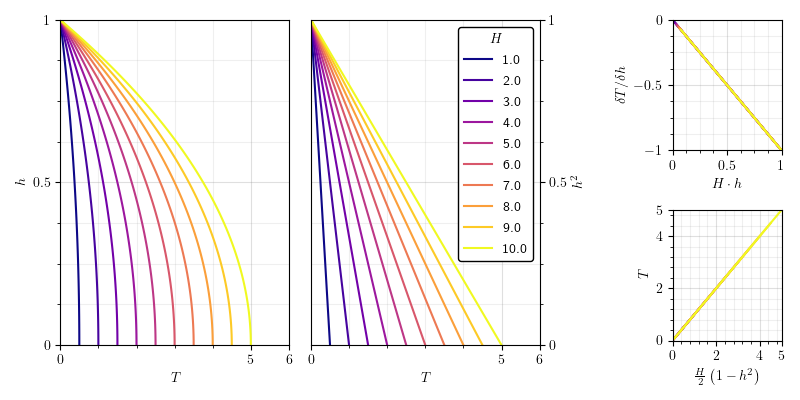

In [3]:
canvas1 = Canvas(shape = (1, 2), size = (6, 4))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

for H, T in zip(condhs, condgeotherms):

    h = np.linspace(0, 1, len(T))
    c = cmap(H, condhs, style = 'plasma')

    ax1.line(
        Tchan := Channel(T, label = 'T', lims = (None, 6.), capped = (True, True)),
        Channel(h, label = 'h'),
        c = c,
        )

    ax2.line(
        Tchan,
        Channel(h**2., label = r"h^{2}", capped = (True, True)),
        c = c,
        )

ax2.props.edges.y.swap()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(round(H, 1)) for H in condhs),
    )
ax2.props.legend.title.text = 'H'
ax2.props.legend.title.visible = True
# ax2.props.legend.mplprops['bbox_to_anchor'] = (1.75, 0.85)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

canvas2 = Canvas(shape = (2, 1), size = (2, 4))
ax1 = canvas2.make_ax((0, 0))
ax2 = canvas2.make_ax((1, 0))

for H, T in zip(condhs, condgeotherms):
    h = np.linspace(0, 1, len(T))
    c = cmap(H, condhs, style = 'plasma')
    y, x = analysis.derivative(T, h)
    ax1.line(
        Channel(x * H, label = r"H \cdot h", lims = (0, 1), capped = (True, True)),
        Channel(y, label = r"\delta T / \delta h", lims = (-1, 0), capped = (True, True)),
        c = c,
        )
    y = T
    x = H / 2 * (1 - h**2)
    ax2.line(
        Channel(x, label = r"\frac{H}{2} \left( 1 - h^2 \right)", lims = (0, 5), capped = (True, True)),
        Channel(y, label = "T", lims = (0, 5), capped = (True, True)),
        c = c,
        )

fig = imop.hstack(canvas1, canvas2)

glue("isocondh", fig, display = False)

fig

In [4]:
with open(osjoin(aliases.storagedir, 'condhfmixed.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condhfs = conddata['hfs']
inddict = {k:v for v, k in enumerate(condhfs)}
condhs = sorted(set(tup[0] for tup in inddict.keys()))[:-1]
selinds = [inddict[H, 1] for H in condhs]
condgeotherms = [conddata['geotherms'][i] for i in selinds]
condavts = [conddata['avts'][i] for i in selinds]

# impaths = sorted(os.path.relpath(path) for path in glob(osjoin(aliases.storagedir, 'cond_hf_mixed_*1-0.png')))
# ims = tuple(image.fromfile(path) for path in impaths)
# ims = (ims[0], *ims[2:], ims[1])
# thumbs = imop.vstack(
#     imop.hstack(*ims[:5]),
#     imop.hstack(*ims[5:]),
#     )

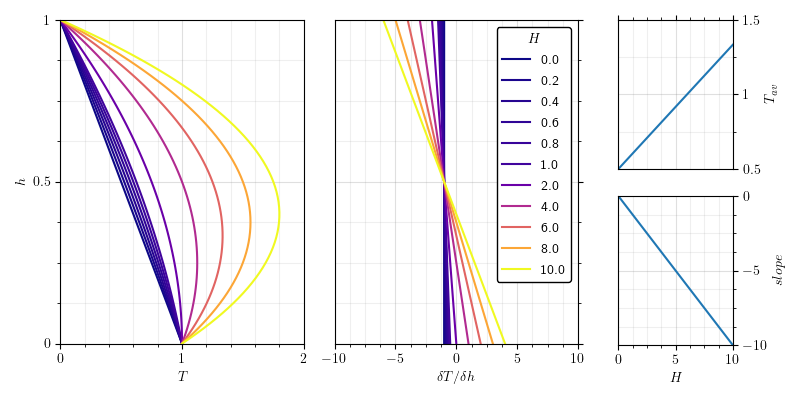

In [5]:
canvas1 = Canvas(shape = (1, 2), size = (6, 4))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

slopeslopes = []

for H, T in zip(condhs, condgeotherms):

    h = np.linspace(0, 1, len(T))
    c = cmap(H, condhs, style = 'plasma')
    dT = np.gradient(T, h, edge_order = 2)
    ddT = np.gradient(dT, h, edge_order = 2)

    ax1.line(
        Channel(T, label = 'T', lims = (None, 2.), capped = (True, True)),
        Channel(h, label = 'h'),
        c = c,
        )
    ax2.line(
        Channel(dT, label = '\delta T / \delta h'),
        Channel(h, label = 'h', lims = (0, 1), capped = (True, True)),
        c = c,
        )
    slopeslopes.append(np.round(ddT.mean(), 2))

ax2.props.edges.y.swap()
ax2.props.edges.y.label.visible = False
ax2.props.edges.y.ticks.major.labels = ()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(H) for H in np.round(condhs, 1)),
    )
ax2.props.legend.title.text = 'H'
ax2.props.legend.title.visible = True
# ax2.props.legend.mplprops['bbox_to_anchor'] = (1., 1.)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

canvas2 = Canvas(shape = (2, 1), size = (2, 4))
ax3 = canvas2.make_ax((0, 0))
ax4 = canvas2.make_ax((1, 0))

ax3.line(
    Channel(condhs, label = 'H', capped = (True, True)),
    Channel(condavts, label = 'T_{av}', lims = (0.5, 1.5), capped = (True, True)),
    )

ax4.line(
    Channel(condhs, label = 'H', capped = (True, True)),
    Channel(slopeslopes, label = 'slope', capped = (True, True))
    )

ax3.props.edges.y.swap()
ax3.props.edges.x.swap()
ax3.props.edges.x.label.visible = False
ax3.props.edges.x.ticks.major.labels = ()

ax4.props.edges.y.swap()

fig = imop.hstack(canvas1, canvas2, pad = (255, 255, 255))
# fig = imop.paste(canvas1, canvas2, coord = (0.5, 0.5))

glue("isocondhmixed", fig, display = False)

fig

# Reproduces exactly
# def myfn1(h, H):
#     return -H * (h - 0.5) - 1
# def myfn2(h, H):
#     return 0.5 * H * h * (1 - h) - h - 1

# canvas2 = Canvas(shape = (1, 2), size = (6, 4))
# ax1 = canvas2.make_ax((0, 0))
# ax2 = canvas2.make_ax((0, 1))
# h = np.linspace(0, 1, 101)
# midh = h[:-1] + np.diff(h) / 2
# for H in condhs:
#     H = 0.0001 if H == 0 else H
#     c = cmap(H, condhs, style = 'turbo')
#     ax1.line(
#         Channel([myfn2(hval, H) for hval in h], label = 'T'),
#         Channel(h, label = 'h'),
#         c = c,
#         )
#     ax2.line(
#         Channel([myfn1(hval, H) for hval in midh], label = '\delta T / \delta h'),
#         Channel(midh, label = 'h', lims = (0, 1), capped = (True, True)),
#         c = c,
#         )

# ax2.props.edges.y.swap()
# ax2.props.edges.y.label.visible = False
# ax2.props.edges.y.ticks.major.labels = ()

# ax2.props.legend.set_handles_labels(
#     (row[0] for row in ax1.collections),
#     (str(H) for H in np.round(condhs, 1)),
#     )
# ax2.props.legend.title.text = 'H'
# ax2.props.legend.title.visible = True
# # ax2.props.legend.mplprops['bbox_to_anchor'] = (1., 1.)
# # ax1.props.legend.mplprops['ncol'] = 2
# ax2.props.legend.frame.colour = 'black'
# ax2.props.legend.frame.visible = True

# canvas2